In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

In [2]:
orthogroups = pd.read_csv(
    "/data/passala/Collaborator_Data/Zach_Pan_solanum_Data/Orthology_Tables/Finalized_Orthology_Nov_15/Reformatted_orthogroup_table.csv"
)

In [3]:
counts = orthogroups.groupby(["Orthogroup", "Species"]).count()
counts = counts.rename(columns={"Gene Name": "Num Genes"})
counts = counts.reset_index()
counts_median = counts.groupby("Orthogroup").median()
counts_paralogs = counts_median.loc[counts_median["Num Genes"] == 2]

In [4]:
orthogroups_paralogs_only = orthogroups.loc[
    orthogroups["Orthogroup"].isin(counts_paralogs.index)
]
orthogroups_paralogs_only
paralog_count = orthogroups_paralogs_only.groupby(["Orthogroup", "Species"]).count()
paralog_count = paralog_count.reset_index()
paralog_count = paralog_count.rename(columns={"Gene Name": "Num Genes"})

In [5]:
tissue_directory = pd.read_csv(
    "/data/passala/Collaborator_Data/Zach_Pan_solanum_Data/Final_species_RNA_data/sample_to_tissue.csv",
    sep="\t",
)
tissue_directory = tissue_directory.replace(
    {
        "apices": "Apex",
        "coty": "Cotyledon",
        "In": "Inflorescence",
        "leaves": "Leaf",
        "hypo": "Hypocotyl",
        "pric": "Prickle",
        "fruit": "Fruit",
        "flower": "Flower",
        "meristem": "Meristem",
    }
)


In [6]:
sensible_species_names = {
    "Solabu2_1.1.2": "abutiloides",
    "Solaet3_1.5.2": "aethiopicum",
    "Solame3_1.1.2": "americanum",
    "Solang8_1.1.2": "anguivi",
    "Solcan1_1.1.2": "candidum",
    "Solcit1_1.1.2": "citrullifolium",
    "Solcle2_1.2.2": "cleistogamum",
    "Soletu1_1.2.2": "etuberosum",
    "Solgig1_1.2.2": "giganteum",
    "Solhav1_1.2.2": "havanense",
    "Solins1_1.1.2": "insanum",
    "Sollin1_1.2.2": "linearifolium",
    "Solmac3_1.5.2": "macrocarpon",
    "Solmam1_1.1.2": "mammosum",
    "Solmur2hap1_1.3.2": "muricatum1",
    "Solmur2hap2_1.3.2": "muricatum2",
    "Solpri1_1.3.2": "prinophyllum",
    "Solpse1_1.1.2.3.2": "pseudolulo",
    "Solqui2_1.3.2": "quitoense",
    "Solrob1_1.2.2": "robustum",
    "Solstr1_1.1.2": "stramoniifolium",
    "Soltor1_1.1.2": "torvum",
    "Solvio1_1.1.2": "violaceum",
}

In [7]:
paralog_count = paralog_count.replace(sensible_species_names)
paralog_count = paralog_count.loc[paralog_count["Species"] != "SlycHeinz4.0"]
gene_ortho_map = orthogroups_paralogs_only.replace(sensible_species_names)
sample_names = tissue_directory[["Species", "Sample"]].drop_duplicates()
sample_names = sample_names[:-1]
ortho_expression_frame = pd.DataFrame(index=counts_paralogs.index)


In [8]:
for species in sample_names.iterrows():
    sample_id = species[1][1]
    species_id = species[1][0]
    file_name = "/data/suresh/pansol/counts/" + sample_id + "_TPM_counts.csv"
    current_rna_file = pd.read_csv(file_name)
    current_rna_file.index = current_rna_file.index.str.split(":").str[1]
    avg_expression = pd.DataFrame(
        current_rna_file.mean(axis=1), columns=["Avg Expression"]
    )
    current_species_genes = gene_ortho_map.loc[gene_ortho_map["Species"] == species_id]
    added_ortho = avg_expression.merge(
        right=current_species_genes[["Gene Name", "Orthogroup"]],
        left_index=True,
        right_on="Gene Name",
    )
    ortho_avgs = added_ortho.groupby("Orthogroup").mean()
    ortho_expression_frame = ortho_expression_frame.merge(
        how="left", right=ortho_avgs, left_index=True, right_index=True
    ).rename(columns={"Avg Expression": species_id})

In [9]:
ortho_groups_and_number_of_genes_present_in_each_species = pd.DataFrame(
    index=counts_paralogs.index
)
for species in sample_names.iterrows():
    sample_id = species[1][1]
    species_id = species[1][0]
    current_list_of_genes = gene_ortho_map.loc[gene_ortho_map["Species"] == species_id]
    all_orthogroups_number_present = []
    for orthogroup in counts_paralogs.index:
        genes_in_orthogroup = current_list_of_genes.loc[
            current_list_of_genes["Orthogroup"] == orthogroup
        ]
        numb_of_that_gene_in_species = len(genes_in_orthogroup)
        all_orthogroups_number_present.append(numb_of_that_gene_in_species)
    ortho_groups_and_number_of_genes_present_in_each_species[
        species_id
    ] = all_orthogroups_number_present

In [11]:
ortho_groups_and_number_of_genes_present_in_each_species[
    "Mean Group Expression"
] = ortho_expression_frame.mean(axis=1)
ortho_groups_and_number_of_genes_present_in_each_species

,abutiloides,aethiopicum,americanum,anguivi,candidum,citrullifolium,cleistogamum,etuberosum,giganteum,havanense,...,muricatum1,muricatum2,prinophyllum,pseudolulo,quitoense,robustum,stramoniifolium,torvum,violaceum,Mean Group Expression
Orthogroup,,,,,,,,,,,,,,,,,,,,,
OG0000179,3,0,1,3,2,10,1,12,2,6,...,1,2,6,0,1,0,5,91,1,2.561265
OG0000411,2,13,13,12,2,2,2,1,3,0,...,4,4,4,0,1,2,2,2,9,2414.040608
OG0000412,1,4,1,3,7,1,1,1,4,2,...,1,0,4,0,4,1,2,1,16,6.844705
OG0000516,0,2,10,2,11,3,2,3,2,4,...,2,2,2,0,10,2,6,2,2,14.861063
OG0000572,8,1,10,1,2,2,1,10,0,4,...,6,5,1,0,2,7,2,6,1,1.158473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG0044289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.000000
OG0044290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.000000
OG0044291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.000000


In [14]:
ortho_groups_and_number_of_genes_present_in_each_species["Frequency of Gene Loss"] = (
    ortho_groups_and_number_of_genes_present_in_each_species < 2
).sum(axis=1)

Text(0.5, 1.0, 'Orthogroups that experience gene loss more frequently are expressed at lower levels')

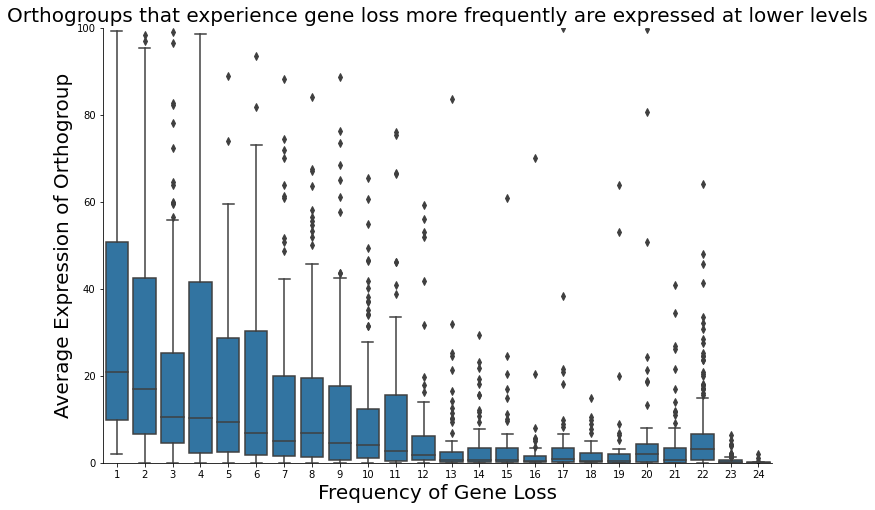

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor("white")
# ax = sns.stripplot(data = ortho_groups_and_number_of_genes_present_in_each_species, x ='Frequency of Gene Loss', y = 'Mean Group Expression', jitter = .25, s = 6, color= 'tab:blue')
ax = sns.boxplot(
    data=ortho_groups_and_number_of_genes_present_in_each_species,
    x="Frequency of Gene Loss",
    y="Mean Group Expression",
    color="tab:blue",
)

plt.ylabel("Average Expression of Orthogroup", fontsize=20)
plt.xlabel("Frequency of Gene Loss", fontsize=20)
sns.despine()

ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# plt.xlim((-7,7))
plt.ylim((0, 100))
plt.title(
    "Orthogroups that experience gene loss more frequently are expressed at lower levels",
    fontsize=20,
)
# plt.xticks(fontsize = 11, ticks = [0,10,20,30,40,50])
# plt.yticks(fontsize = 11)

In [16]:
methylation_data = pd.read_csv('/data/suresh/pansol/Saet3_methylation.csv')

In [17]:
methylation_data

,chr,start,end,type,nCG.segmentation,nCG.seq,mean.meth,median.meth,Gene
0,Saet_chr1,54534,55604,LMR,9,9,3.151862,2.609087,Solaet3_01g000010
1,Saet_chr1,56632,57520,LMR,14,14,23.898305,14.111498,Solaet3_01g000020
2,Saet_chr1,62880,63888,LMR,7,7,4.154303,3.334196,Solaet3_01g000030
3,Saet_chr1,70290,71500,LMR,15,15,7.785888,1.876939,Solaet3_01g000050
4,Saet_chr1,74391,77190,UMR,36,36,13.175886,3.163629,Solaet3_01g000050
...,...,...,...,...,...,...,...,...,...
32230,Saet_chrM,18058,445700,UMR,928,16734,2.461032,2.287582,Solaet3_Mg002140
32231,Saet_chrM,18058,445700,UMR,928,16734,2.461032,2.287582,Solaet3_Mg002210
32232,Saet_chrM,18058,445700,UMR,928,16734,2.461032,2.287582,Solaet3_Mg002220
32233,Saet_chrM,18058,445700,UMR,928,16734,2.461032,2.287582,Solaet3_Mg002270


In [23]:
meth_results = methylation_data[['median.meth','Gene']].groupby('Gene').mean()
meth_results

,median.meth
Gene,
Solaet3_01g000010,2.609087
Solaet3_01g000020,14.111498
Solaet3_01g000030,3.334196
Solaet3_01g000050,2.520284
Solaet3_01g000060,3.163629
...,...
Solaet3_Mg002140,2.287582
Solaet3_Mg002210,2.287582
Solaet3_Mg002220,2.287582


In [22]:
orthogroups

,Gene Name,Orthogroup,Species
0,Solyc04g018150,OG0000003,SlycHeinz4.0
1,Solyc02g030550,OG0000004,SlycHeinz4.0
2,Solyc01g066020,OG0000005,SlycHeinz4.0
3,Solyc05g024370,OG0000005,SlycHeinz4.0
4,Solyc11g011080,OG0000005,SlycHeinz4.0
...,...,...,...
877265,Solvio1_09g012150,OG0044291,Solvio1_1.1.2
877266,Solvio1_11g011120,OG0044292,Solvio1_1.1.2
877267,Solvio1_11g018310,OG0044292,Solvio1_1.1.2
877268,Solvio1_11g011570,OG0044293,Solvio1_1.1.2


In [27]:
meth_results = meth_results.merge(right = orthogroups[['Gene Name','Orthogroup']], left_index= True, right_on='Gene Name')

In [31]:
meth_results

,median.meth,Gene Name,Orthogroup
113540,2.609087,Solaet3_01g000010,OG0005857
117038,14.111498,Solaet3_01g000020,OG0009243
114459,3.334196,Solaet3_01g000030,OG0006714
117036,2.520284,Solaet3_01g000050,OG0009241
126279,3.163629,Solaet3_01g000060,OG0018447
...,...,...,...
109500,2.287582,Solaet3_Mg002140,OG0003040
130363,2.287582,Solaet3_Mg002210,OG0022576
109864,2.287582,Solaet3_Mg002220,OG0003227
111429,2.287582,Solaet3_Mg002270,OG0004156


In [32]:
max_ortho = meth_results[['median.meth','Orthogroup']].groupby('Orthogroup').max()

In [33]:
max_ortho

,median.meth
Orthogroup,
OG0000000,4.493257
OG0000003,7.816092
OG0000004,6.782751
OG0000005,32.307692
OG0000006,23.683093
...,...
OG0039392,2.641056
OG0039400,18.203098
OG0039401,20.116959


In [34]:
ortho_groups_and_number_of_genes_present_in_each_species

,abutiloides,aethiopicum,americanum,anguivi,candidum,citrullifolium,cleistogamum,etuberosum,giganteum,havanense,...,muricatum2,prinophyllum,pseudolulo,quitoense,robustum,stramoniifolium,torvum,violaceum,Mean Group Expression,Frequency of Gene Loss
Orthogroup,,,,,,,,,,,,,,,,,,,,,
OG0000179,3,0,1,3,2,10,1,12,2,6,...,2,6,0,1,0,5,91,1,2.561265,9
OG0000411,2,13,13,12,2,2,2,1,3,0,...,4,4,0,1,2,2,2,9,2414.040608,5
OG0000412,1,4,1,3,7,1,1,1,4,2,...,0,4,0,4,1,2,1,16,6.844705,10
OG0000516,0,2,10,2,11,3,2,3,2,4,...,2,2,0,10,2,6,2,2,14.861063,2
OG0000572,8,1,10,1,2,2,1,10,0,4,...,5,1,0,2,7,2,6,1,1.158473,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG0044289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0.000000,23
OG0044290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0.000000,23
OG0044291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0.000000,23


In [35]:
methylation_ortho = ortho_groups_and_number_of_genes_present_in_each_species.merge(right = max_ortho, left_index= True, right_index= True)

In [36]:
methylation_ortho[]

,abutiloides,aethiopicum,americanum,anguivi,candidum,citrullifolium,cleistogamum,etuberosum,giganteum,havanense,...,prinophyllum,pseudolulo,quitoense,robustum,stramoniifolium,torvum,violaceum,Mean Group Expression,Frequency of Gene Loss,median.meth
Orthogroup,,,,,,,,,,,,,,,,,,,,,
OG0000411,2,13,13,12,2,2,2,1,3,0,...,4,0,1,2,2,2,9,2414.040608,5,19.146341
OG0000412,1,4,1,3,7,1,1,1,4,2,...,4,0,4,1,2,1,16,6.844705,10,43.243243
OG0000639,3,8,2,7,1,2,3,2,5,1,...,2,0,1,2,0,4,11,18.234526,5,7.242822
OG0000675,0,1,0,1,20,1,3,1,2,1,...,0,0,12,6,12,4,2,0.667547,14,2.251326
OG0000734,2,3,11,3,2,7,2,6,3,3,...,2,0,2,3,2,2,2,27.482364,2,9.641208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG0038969,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.998774,23,2.273119
OG0039023,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.111179,23,4.397819
OG0039029,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.956816,22,9.722222


Text(0.5, 1.0, 'Full Gene loss uniformative')

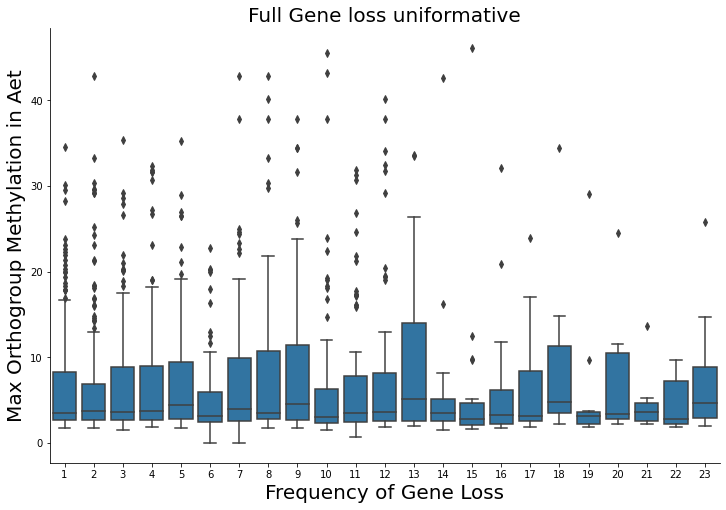

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor("white")
# ax = sns.stripplot(data = ortho_groups_and_number_of_genes_present_in_each_species, x ='Frequency of Gene Loss', y = 'Mean Group Expression', jitter = .25, s = 6, color= 'tab:blue')
ax = sns.boxplot(
    data=methylation_ortho,
    x="Frequency of Gene Loss",
    y="median.meth",
    color="tab:blue",
)

plt.ylabel("Max Orthogroup Methylation in Aet", fontsize=20)
plt.xlabel("Frequency of Gene Loss", fontsize=20)
sns.despine()

ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# plt.xlim((-7,7))
#plt.ylim((0, 100))
plt.title(
    "Full Gene loss uniformative",
    fontsize=20,
)
# plt.xticks(fontsize = 11, ticks = [0,10,20,30,40,50])
# plt.yticks(fontsize = 11)

In [39]:
aetheiopicum_frame = methylation_ortho[["aethiopicum","Mean Group Expression",'median.meth']]
aetheiopicum_frame

,aethiopicum,Mean Group Expression,median.meth
Orthogroup,,,
OG0000411,13,2414.040608,19.146341
OG0000412,4,6.844705,43.243243
OG0000639,8,18.234526,7.242822
OG0000675,1,0.667547,2.251326
OG0000734,3,27.482364,9.641208
...,...,...,...
OG0038969,2,0.998774,2.273119
OG0039023,2,1.111179,4.397819
OG0039029,2,3.956816,9.722222


In [41]:
aetheiopicum_frame.min()

aethiopicum                     1
Mean Group Expression    0.003679
median.meth                   0.0
Status                   Expanded
dtype: object

In [40]:
aetheiopicum_frame['Status'] = 'unassigned'
aetheiopicum_frame['Status'].loc[aetheiopicum_frame['aethiopicum']>2] = 'Expanded'
aetheiopicum_frame['Status'].loc[aetheiopicum_frame['aethiopicum'] == 2] = 'Paralogous'
aetheiopicum_frame['Status'].loc[aetheiopicum_frame['aethiopicum'] == 1] = 'Gene loss'

/tmp/ipykernel_335476/3336335904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aetheiopicum_frame['Status'] = 'unassigned'
/tmp/ipykernel_335476/3336335904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aetheiopicum_frame['Status'].loc[aetheiopicum_frame['aethiopicum']>2] = 'Expanded'
/tmp/ipykernel_335476/3336335904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [42]:
aetheiopicum_frame

,aethiopicum,Mean Group Expression,median.meth,Status
Orthogroup,,,,
OG0000411,13,2414.040608,19.146341,Expanded
OG0000412,4,6.844705,43.243243,Expanded
OG0000639,8,18.234526,7.242822,Expanded
OG0000675,1,0.667547,2.251326,Gene loss
OG0000734,3,27.482364,9.641208,Expanded
...,...,...,...,...
OG0038969,2,0.998774,2.273119,Paralogous
OG0039023,2,1.111179,4.397819,Paralogous
OG0039029,2,3.956816,9.722222,Paralogous


Text(0.5, 1.0, 'Orthogroups that experience gene loss more frequently are expressed at lower levels')

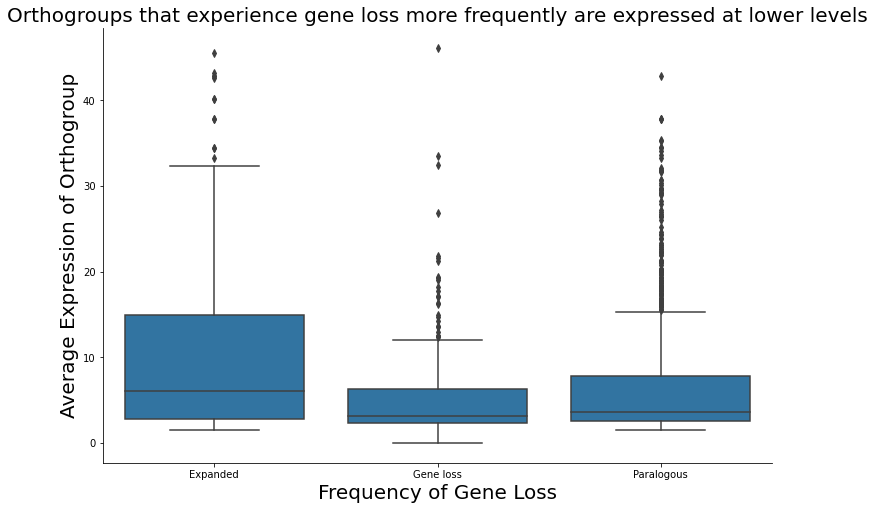

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor("white")
# ax = sns.stripplot(data = ortho_groups_and_number_of_genes_present_in_each_species, x ='Frequency of Gene Loss', y = 'Mean Group Expression', jitter = .25, s = 6, color= 'tab:blue')
ax = sns.boxplot(
    data=aetheiopicum_frame,
    x="Status",
    y="median.meth",
    color="tab:blue",
)

plt.ylabel("Average Expression of Orthogroup", fontsize=20)
plt.xlabel("Frequency of Gene Loss", fontsize=20)
sns.despine()

ax.grid(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# plt.xlim((-7,7))
#plt.ylim((0, 100))
plt.title(
    "Orthogroups that experience gene loss more frequently are expressed at lower levels",
    fontsize=20,
)
# plt.xticks(fontsize = 11, ticks = [0,10,20,30,40,50])
# plt.yticks(fontsize = 11)